## Recursive Least Squares

In [6]:
import numpy as np
from sklearn.metrics import explained_variance_score, root_mean_squared_error
from sklearn.pipeline import Pipeline

from sippy_unipi.datasets import load_sample_siso
from sippy_unipi.io import ARARMAX, ARARX, ARMA, BJ, GEN, OE
from sippy_unipi.plot import (
    plot_comparison,
    plot_responses,
)
from sippy_unipi.preprocessing import StandardScaler

np.random.seed(0)
ylegends = ["System", "ARMA", "ARARX", "ARARMAX", "OE", "BJ", "GEN"]

# Enable automatic reloading of modules when they change
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


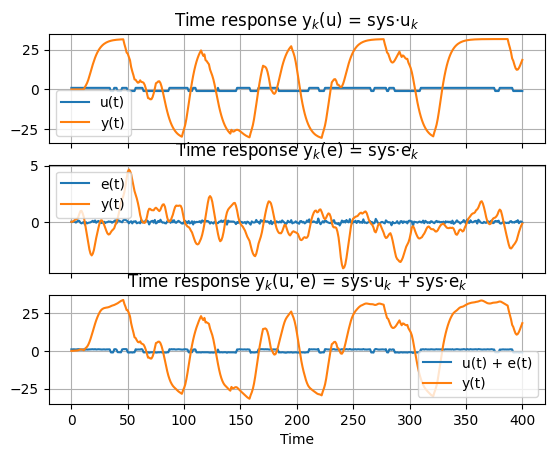

In [16]:
# Load sample data
n_samples = 401
ts = 1.0
time, Ysim, Usim, g_sys, Yerr, Uerr, h_sys, Ytot, Utot = load_sample_siso(
    n_samples, ts, seed=0
)

# Plot input and output responses
fig = plot_responses(
    time,
    [Usim, Uerr, Utot],
    [Ysim, Yerr, Ytot],
    ["u", "e", ["u", "e"]],
)

In [17]:
na = 2
nb = 3
nc = 2
nd = 3
nf = 4
theta = 11
stab_cons = False
method = "rlls"
models = [
    ARMA(na, nc, theta, stab_cons=stab_cons, method=method),
    ARARX(na, nb, nd, theta, stab_cons=stab_cons, method=method),
    ARARMAX(na, nb, nc, nd, theta, stab_cons=stab_cons, method=method),
    OE(nb, nf, theta, stab_cons=stab_cons, method=method),
    BJ(nb, nc, nd, nf, theta, stab_cons=stab_cons, method=method),
    GEN(na, nb, nc, nd, nf, theta, stab_cons=stab_cons, method=method),
]

In [21]:
ys = [Ytot]
scores = {"rmse": [], "ev": []}
fitted_models = []
for model in models:
    sys = Pipeline(
        [
            ("scaler", StandardScaler(with_mean=False)),
            ("model", model),
        ]
    )
    sys.fit(Utot.reshape(-1, 1), Ytot.reshape(-1, 1))
    fitted_models.append(sys)
    Y_pred = sys.predict(Utot.reshape(-1, 1), safe=True)
    scores["rmse"].append(root_mean_squared_error(Ytot, Y_pred))
    scores["ev"].append(explained_variance_score(Ytot, Y_pred))
    ys.append(Y_pred)

In [22]:
# Print scores in a formatted table
print("Model Performance Metrics:")
print("-" * 50)
print(f"{'Model':<20} {'RMSE':<10} {'Explained Variance':<20}")
print("-" * 50)

for i, model_name in enumerate(ylegends):
    if i == 0:  # Skip the first one which is the actual data
        continue
    rmse_value = scores["rmse"][i - 1]
    ev_value = scores["ev"][i - 1]
    print(f"{model_name:<20} {rmse_value:<10.4f} {ev_value:<20.4f}")
print("-" * 50)


Model Performance Metrics:
--------------------------------------------------
Model                RMSE       Explained Variance  
--------------------------------------------------
ARMA                 21.0657    0.0428              
ARARX                21.5629    0.0000              
ARARMAX              21.5629    0.0000              
OE                   2.0699     0.9898              
BJ                   21.5629    0.0000              
GEN                  21.5629    0.0000              
--------------------------------------------------


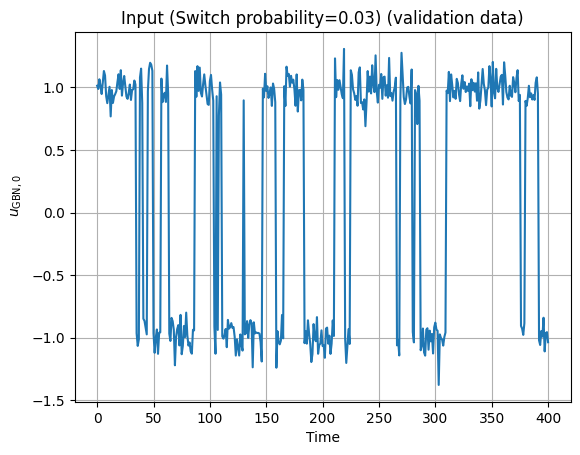

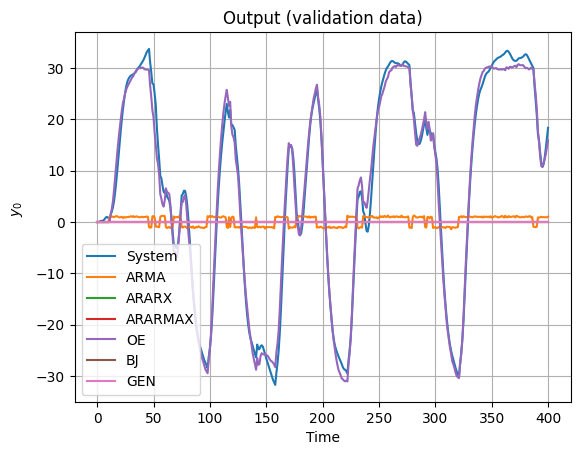

In [24]:
fig = plot_comparison(
    time,
    Utot,
    [r"$u_\mathrm{GBN, " + str(i) + "}$" for i in range(Utot.shape[1])],
    title="Input (Switch probability=0.03) (validation data)",
)

fig = plot_comparison(
    time,
    ys,
    ylabels=[f"$y_{i}$" for i in range(3)],
    legend=["System"] + [model.__class__.__name__ for model in models],
    title="Output (validation data)",
)